<div style="border: 2px solid blue; padding: 5px; color: red; text-align: center; font-size: 24px;">
 Text Classification
</div>

Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as:
1. Tagging customer feedback into categories
2. Routing support tickets according to their language
3. Email filtering
4. Sentiment analysis

Now imagine that you are a data scientist who needs to build a system that can automatically identify emotional states such as "anger" or "joy" that people express about your company's product on Twitter. We'll tackle this task using a variant of BERT called **DistilBERT**. The main advantage of this model is that it achieves comparable performance to BERT, while being significantly smaller and more efficient.



# Dataset

 Through this tutorial, we will use a dataset avalaible in HuggingFace. Unlike most sentiment analysis datasets that involve just "positive" and "negative" polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise. Given a tweet, our task will be to train a model that can classify it into one of these emotions.

In [1]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

sns.set_theme(style="dark")

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("emotion")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:

dataset.set_format(type="pandas")
df = dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Labels are encoded. The dataset instance helps to retrieve the classes names.

In [5]:
def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

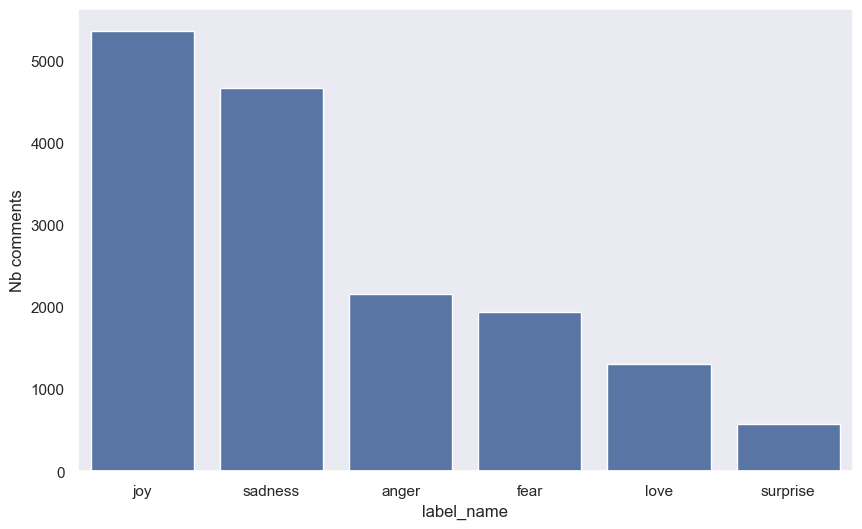

In [6]:
plt.figure(figsize=(10, 6))
# Order labels by frequency and plot horizontal bar plot
sns.countplot(data=df, x="label_name", order=df["label_name"].value_counts().index)
plt.ylabel("Nb comments")
plt.show()

In this case, we can see that the dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas **love and surprise** are about 5–10 times rarer. There are several ways to deal with imbalanced data, including:
1. Randomly oversample the minority class.
2. Randomly undersample the majority class.
3. Gather more labeled data from the underrepresented classes.

For this tutorial, we will not deal with the umbalanced issue. We want to see what method fit the most with umbalanced data.

## Tweets lenght

Transformer models have a maximum input sequence length that is referred to as the maximum context size. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. It is important to know the lenght of your comments before using a transformers.


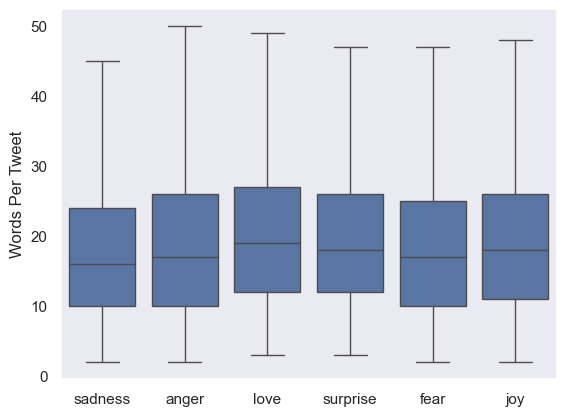

In [7]:

df["Words Per Tweet"] = df["text"].str.split().apply(len)
# df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
#            color="black")
sns.boxplot(data=df, x="label_name", y="Words Per Tweet", showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [8]:
df.head()

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


From the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

In [9]:
dataset.reset_format()

# Tokenization

The `AutoTokenizer` class belongs to a larger set of "auto" classes whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well.

In [10]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mbial\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWa

In [11]:
print(f"Tokenizer vocab size: {tokenizer.vocab_size} \n")
print(f"Tokenizer special tokens: {tokenizer.all_special_tokens}\n")
print(f"Tokenizer max length: {tokenizer.model_max_length}\n")
print(f"Tokenizer model inpus name: {tokenizer.model_input_names}\n")

Tokenizer vocab size: 30522 

Tokenizer special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

Tokenizer max length: 512

Tokenizer model inpus name: ['input_ids', 'attention_mask']



When using pretrained models, it is really important to make sure that you use the same tokenizer that the model was trained with. From the model's perspective, switching the tokenizer is like shuffling the vocabulary. 

In [39]:
?tokenizer

Signature:     
tokenizer(
    text: Union[str, List[str], List[List[str]]] = None,
    text_pair: Union[str, List[str], List[List[str]], NoneType] = None,
    text_target: Union[str, List[str], List[List[str]]] = None,
    text_pair_target: Union[str, List[str], List[List[str]], NoneType] = None,
    add_special_tokens: bool = True,
    padding: Union[bool, str, transformers.utils.generic.PaddingStrategy] = False,
    truncation: Union[bool, str, transformers.tokenization_utils_base.TruncationStrategy] = None,
    max_length: Optional[int] = None,
    stride: int = 0,
    is_split_into_words: bool = False,
    pad_to_multiple_of: Optional[int] = None,
    padding_side: Optional[bool] = None,
    return_tensors: Union[str, transformers.utils.generic.TensorType, NoneType] = None,
    return_token_type_ids: Optional[bool] = None,
    return_attention_mask: Optional[bool] = None,
    return_overflowing_tokens: bool = False,
    return_special_tokens_mask: bool = False,
    return_offsets_

In [61]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, return_tensors='pt')

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize, batched=True, batch_size=None)

In [62]:

print(tokenized_dataset["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Classifier Model

We have two options to train such a model on our Twitter dataset:

1. **Feature extraction**: We use the hidden states of the pre-trained model as features and just train a classifier on them, without modifying the pretrained model.

2. **Fine-tuning**: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In the following sections we explore both options for DistilBERT and examine their trade-offs.

## Transformers as Feature Extractors

Using a transformer as a feature extractor is fairly simple. We freeze the body's weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

**Feature Extraction**: Feature extraction refers to using a pre-trained model as a fixed feature extractor. Instead of modifying the model’s weights, the model is used to extract relevant features from the input data. These features can then be fed into a new classifier or model specific to the target task

In [58]:

# hide_output
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [63]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [64]:

tokenized_dataset.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [69]:
text = "Hello how are you doing today ?"
outputs = tokens = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=30,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

In [70]:
outputs

{'input_ids': tensor([[ 101, 7592, 2129, 2024, 2017, 2725, 2651, 1029,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])}

In [71]:
results = model(**outputs)

In [83]:
results['last_hidden_state'].shape

torch.Size([1, 30, 768])

In [84]:
results['last_hidden_state'].mean(axis=1)

tensor([[-9.7473e-02, -1.3388e-01,  1.3185e-02, -1.1257e-02,  2.0608e-01,
         -2.0470e-01,  9.0917e-02,  5.0615e-01, -2.0330e-01, -3.9879e-01,
          1.9756e-01, -8.7199e-02, -4.4987e-02,  8.8400e-02, -9.5878e-02,
          4.1856e-01,  2.1202e-01,  1.7751e-01, -1.0021e-01,  4.7137e-02,
         -2.9811e-02, -2.3224e-01,  1.9923e-02,  6.4801e-02,  1.8818e-01,
         -8.2708e-02, -6.6038e-02,  5.2318e-02,  9.9949e-02, -3.6184e-01,
         -2.2551e-02,  1.8608e-02,  9.4267e-02,  1.1665e-01, -1.8348e-01,
          2.5849e-01, -5.4939e-02, -1.5321e-02, -3.5682e-01,  1.2337e-01,
         -5.7226e-01, -4.9011e-01,  1.2621e-01,  1.1967e-01, -1.5607e-01,
         -3.9021e-01,  1.0241e-01, -2.6297e-01, -1.6402e-02, -9.8215e-02,
          5.8853e-02,  2.9830e-01, -1.1644e-01, -8.7330e-02, -2.0204e-01,
          3.2266e-01, -6.7057e-02, -3.9436e-01, -4.4211e-01, -8.7512e-02,
          1.6087e-01, -3.6404e-01, -1.7866e-01, -1.3866e-01,  1.3972e-01,
          2.9436e-01,  2.6974e-01,  2.

In [65]:
emotions_hidden = tokenized_dataset.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 2000/2000 [01:02<00:00, 32.08 examples/s]


In [85]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [87]:
emotions_hidden["train"][15]

{'label': tensor(1),
 'input_ids': tensor([  101,  1045,  2079,  2025,  2514, 26350, 10089,  2003,  2006,  2169,
          2217,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

Now that we have the hidden states associated with each tweet, the next step is to train a classifier on them. To do that, we'll need a feature matrix - let's take a look

In [86]:

import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Let's visualize the dataframe.

In [88]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.365527,5.940481,0
1,-2.893047,5.191242,0
2,5.474094,2.498385,3
3,-2.249108,3.209394,2
4,-3.255125,3.211215,3


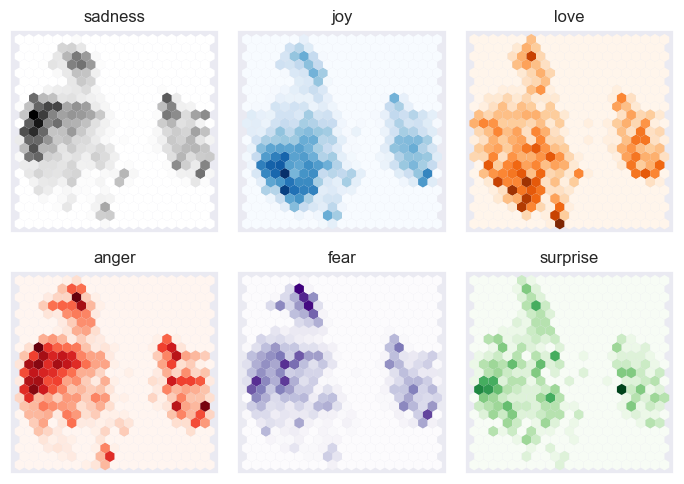

In [97]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: 

1. the negative feelings such as sadness, anger, and fear all occupy similar regions with slightly varying distributions. 
2. Joy and love are well separated from the negative emotions and also share a similar space. 
3. Surprise is scattered all over the place. 

## Training a simple classifier

In [ ]:
# !pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 15.1 MB/s eta 0:00:00


In [91]:
from lightgbm import LGBMClassifier

In [92]:
# train a lgbm regressor
lgbm_classifier = LGBMClassifier(n_estimators=1000, random_state=42)

In [93]:
lgbm_classifier.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 768
[LightGBM] [Info] Start training from score -1.232287
[LightGBM] [Info] Start training from score -1.093252
[LightGBM] [Info] Start training from score -2.507152
[LightGBM] [Info] Start training from score -2.002944
[LightGBM] [Info] Start training from score -2.111448
[LightGBM] [Info] Start training from score -3.331205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

LGBMClassifier(n_estimators=1000, random_state=42)

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [95]:
y_train

array([0, 0, 3, ..., 1, 3, 0], dtype=int64)

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


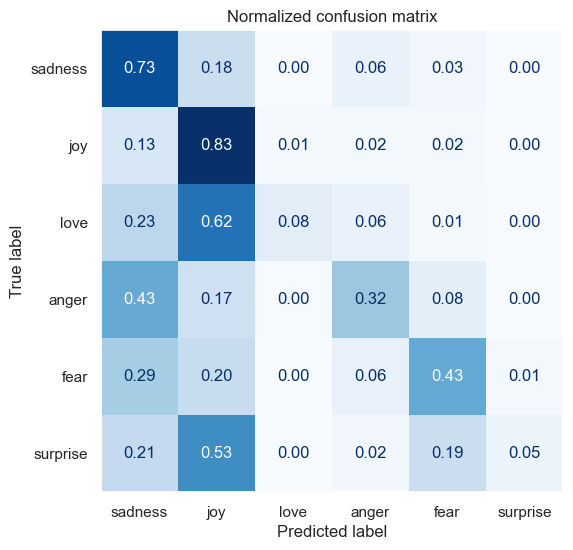

In [98]:
y_preds = lgbm_classifier.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees with the observation we made when visualizing the embeddings. Also, love and surprise are frequently mistaken for joy.

In the next section we will explore the fine-tuning approach, which leads to superior classification performance. It is, however, important to note that doing this requires more computational resources, such as GPUs, that might not be available in your organization. In cases like these, a feature-based approach can be a good compromise between doing traditional machine learning and deep learning.

## Fine-Tuning Transformers

**Fine-tuning**: Fine-tuning involves taking a pre-trained model (often on a source task) and training it further on a target task. During fine-tuning, the model’s weights are updated using the target task’s data while retaining some knowledge from the source task. Fine-tuning is particularly useful when the source and target tasks are closely related.

In [99]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))
     

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

In [101]:

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [102]:

from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

c:\Users\mbial\miniconda3\envs\nkobo\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [103]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset["train"],
                  eval_dataset=tokenized_dataset["validation"],
                  tokenizer=tokenizer)

In [ ]:
trainer.train();

 50%|█████     | 250/500 [29:44<22:58,  5.52s/it] 

{'loss': 0.8223, 'grad_norm': 5.014378070831299, 'learning_rate': 1e-05, 'epoch': 1.0}



 50%|█████     | 250/500 [30:28<22:58,  5.52s/it]

{'eval_loss': 0.30153635144233704, 'eval_accuracy': 0.9105, 'eval_f1': 0.9096717159784368, 'eval_runtime': 44.0972, 'eval_samples_per_second': 45.354, 'eval_steps_per_second': 0.726, 'epoch': 1.0}


 66%|██████▋   | 332/500 [38:14<15:55,  5.69s/it]  

In [57]:
preds_output = trainer.predict(tokenized_dataset["validation"])

preds_output.metrics

  0%|          | 0/32 [00:00<?, ?it/s]

{'test_loss': 0.21132703125476837,
 'test_accuracy': 0.925,
 'test_f1': 0.9249183740191296,
 'test_runtime': 3.748,
 'test_samples_per_second': 533.621,
 'test_steps_per_second': 8.538}

In [58]:
y_preds = np.argmax(preds_output.predictions, axis=1)

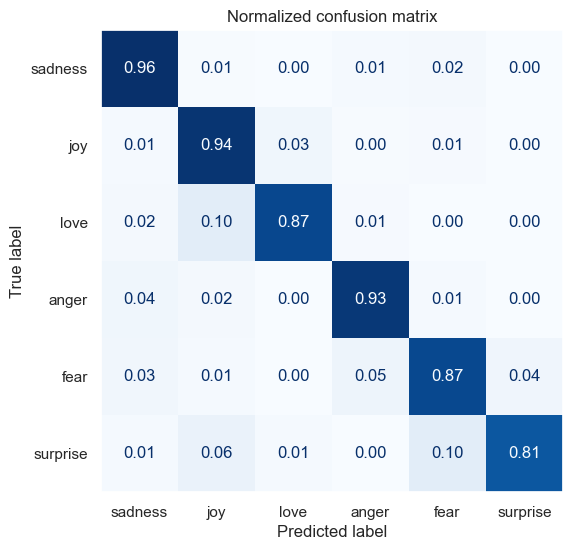

In [59]:

plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix. The love category is still often confused with joy, which seems natural. surprise is also frequently mistaken for joy, or confused with fear. Overall the performance of the model seems quite good.